# Modality comparison across brain regions

In [1]:
library(tidyverse)
library(ComplexHeatmap)

-- Attaching packages --------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ------------------------------------------------------------------------------------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: grid

ComplexHeatmap version 2.6.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

This message can be suppressed by:
  sup

## Upset plots for sharing

### Functions

In [18]:
subset_by_modal_cat <- function(tissue, mod_cat)
{
    fn = paste0("../../../", tissue, "/bimodal_detection/",
                "summarize_modality/_m/diffExpr_AAvsEA_annotated_modality.tsv")
    df <- data.table::fread(fn) %>% 
        mutate(ensemblID=gsub("\\..*", "", gencodeID)) %>%
        filter(Modal_Category == mod_cat)
    return(df$ensemblID)
}

make_list <- function(mod_cat){
    caudate = subset_by_modal_cat('caudate', mod_cat)
    dlpfc = subset_by_modal_cat('dlpfc', mod_cat)
    hippo = subset_by_modal_cat('hippocampus', mod_cat)
    gyrus = subset_by_modal_cat("dentateGyrus", mod_cat)

    lt = list(Caudate = caudate, 
              `Dentate Gyrus` = gyrus,
              DLPFC = dlpfc,
              Hippocampus = hippo)
    m = make_comb_mat(lt)
    return(m)
}

plot_n_save <- function(mod_cat, y1, y2){
    cbb_palette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", 
                     "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
    m <- make_list(mod_cat)
    right_annot = upset_right_annotation(
        m, ylim = c(0, y1), gp = gpar(fill = "black"),
        annotation_name_side = "top", axis_param = list(side = "top"))
    top_annot = upset_top_annotation(
        m, height=unit(7, "cm"), ylim = c(0, y2),
        gp=gpar(fill=cbb_palette[comb_degree(m)]),
        annotation_name_rot = 90)
    pdf(paste0('upsetplot_',mod_cat, ".pdf"), width=8, height=4)
    ht = draw(UpSet(m, pt_size=unit(4, "mm"), lwd=3, 
                    comb_col=cbb_palette[comb_degree(m)], 
                    set_order = c("Caudate", "DLPFC", "Hippocampus", "Dentate Gyrus"), 
                    comb_order = order(-comb_size(m)), 
                    row_names_gp = gpar(fontsize = 14, fontface='bold'),
                    right_annotation = right_annot, 
                    top_annotation = top_annot))
    od = column_order(ht)
    cs = comb_size(m)
    decorate_annotation("intersection_size", {
    grid.text(cs[od], x = seq_along(cs), y = unit(cs[od], "native") + unit(6, "pt"), 
              default.units = "native", just = "bottom", gp = gpar(fontsize = 11))
    })
    dev.off()
}


### Plot and save

In [19]:
mod_cat = c("One_vs_One", "One_vs_Multi", "Multi_vs_One", "Multi_vs_Multi")

plot_n_save(mod_cat[1], 4000, 2000)
plot_n_save(mod_cat[2], 1000, 800)
plot_n_save(mod_cat[3], 1000, 800)
plot_n_save(mod_cat[4], 600, 500)

png 
  2

png 
  2

png 
  2

png 
  2

## Comparison of opposites

In [21]:
library(yardstick)
library(ggplot2)

For binary classification, the first factor level is assumed to be the event.
Use the argument `event_level = "second"` to alter this as needed.


Attaching package: 'yardstick'


The following object is masked from 'package:readr':

    spec




In [22]:
save_plot <- function(p, fn){
    for(ext in c(".pdf", ".png", ".svg")){
        ggsave(filename=paste0(fn,ext), plot=p)
    }
}

plot_heatmap <- function(dt, tissue1, tissue2){
    df = dt %>%
        pivot_wider(names_from = ensemblID, values_from = Modal_Category) %>%
        column_to_rownames("Tissue") %>% t %>% as.data.frame %>%
        mutate_if(is.character, as.factor) %>% conf_mat(tissue1, tissue2)
    htm = autoplot(df, type="heatmap") + 
        xlab(str_replace(tissue1, "_", " ")) + 
        ylab(str_replace(tissue2, "_", " ")) +
        theme_bw() + 
        theme(axis.line = element_blank(), 
              axis.text.x = element_text(angle = 45, hjust=1), 
              axis.text = element_text(size=14), 
              axis.title = element_text(size=18, face="bold"),
              axis.ticks = element_blank(), 
              legend.position="none", panel.grid = element_blank(), 
              strip.text=element_text(size=14, face="bold"))
    print(htm)
    save_plot(htm, paste("confusion_heatmap_modality", 
                         tissue1, tissue2, sep='_'))
    
}

In [23]:
dt = list()
for(tissue in c('caudate', 'dlpfc', 'hippocampus', 'dentateGyrus')){
    fn = paste0("../../../", tissue, "/bimodal_detection/",
                "summarize_modality/_m/diffExpr_AAvsEA_annotated_modality.tsv")
    df = data.table::fread(fn) %>% 
        mutate(ensemblID=gsub("\\..*", "", gencodeID)) %>%
        select('ensemblID', 'Modal_Category', 'Tissue')
    dt[[tissue]] <- df
}

bigdf = bind_rows(dt)
bigdf %>% data.table::fwrite("shared_modality_annotated.tsv", sep='\t')
bigdf %>% dim
bigdf %>% head(2)

[1] 17222     3

ensemblID,Modal_Category,Tissue
<chr>,<chr>,<chr>
ENSG00000233913,Multi_vs_Multi,Caudate
ENSG00000204894,Multi_vs_Multi,Caudate


In [24]:
shared_degs = data.table::fread("../../upset_plots/_m/BrainSeq_shared_degs_annotation.txt")
shared_df = bigdf %>% filter(ensemblID %in% shared_degs$ensemblID)
shared_df %>% dim
shared_df %>% head(2)

[1] 2568    3

ensemblID,Modal_Category,Tissue
<chr>,<chr>,<chr>
ENSG00000233913,Multi_vs_Multi,Caudate
ENSG00000272977,Multi_vs_One,Caudate


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



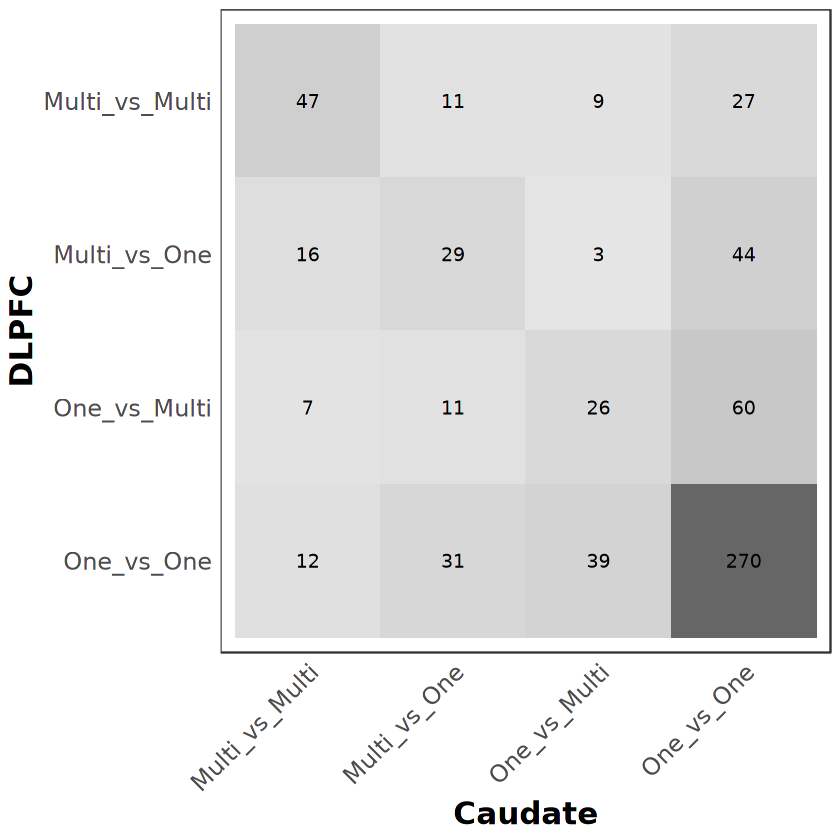

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



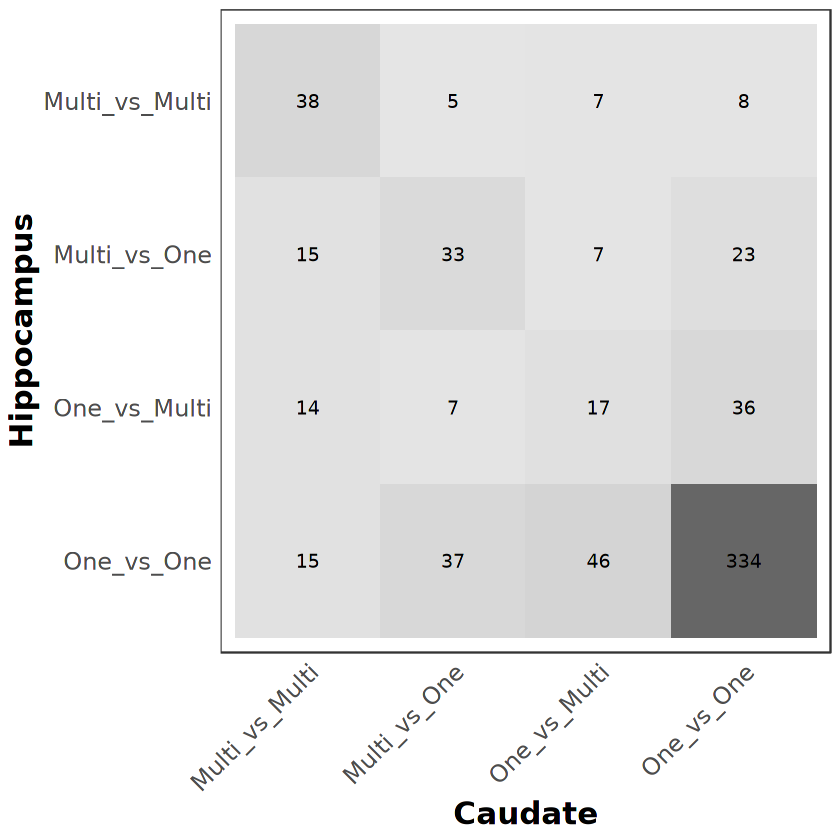

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



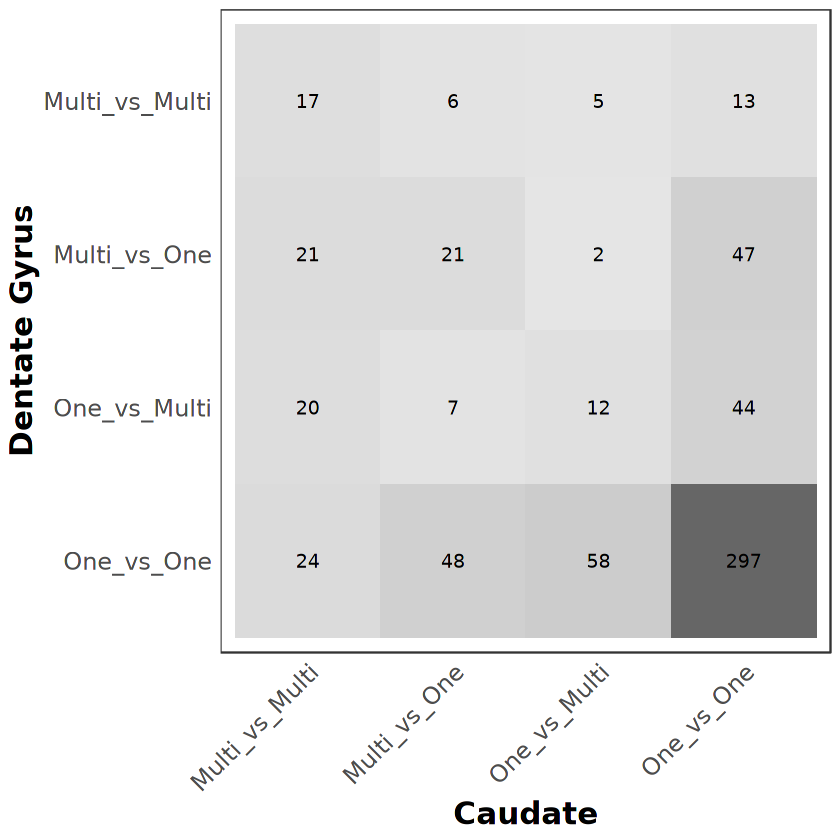

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



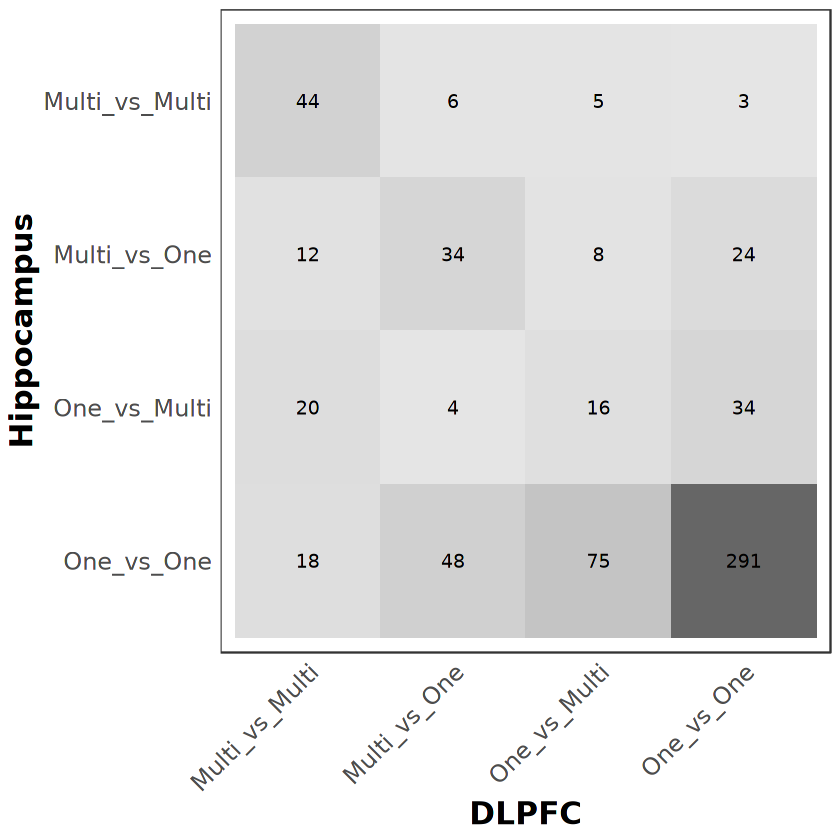

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



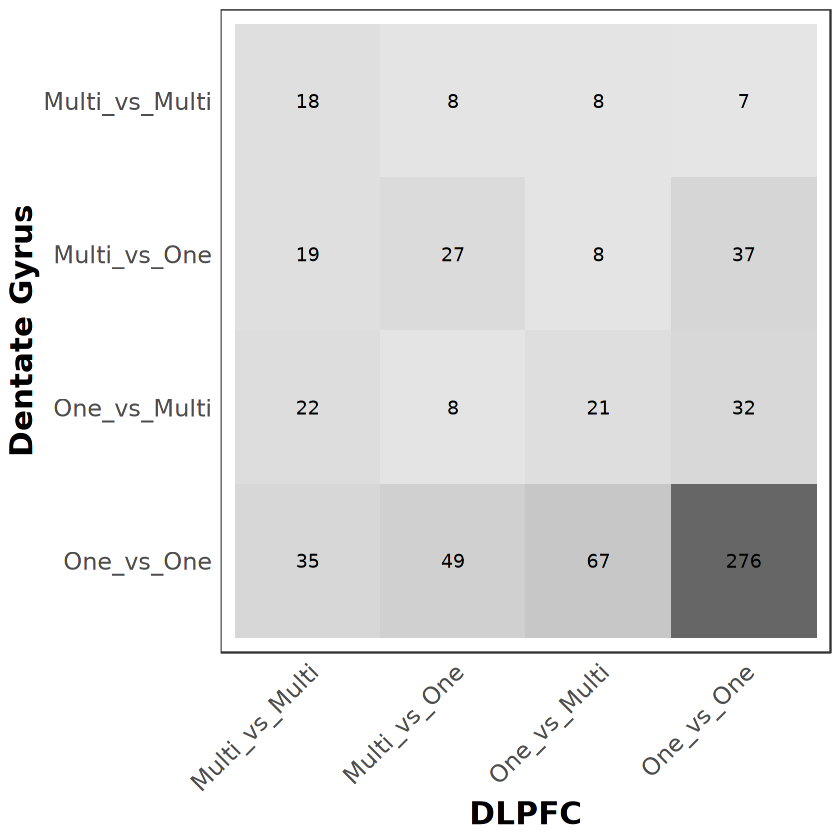

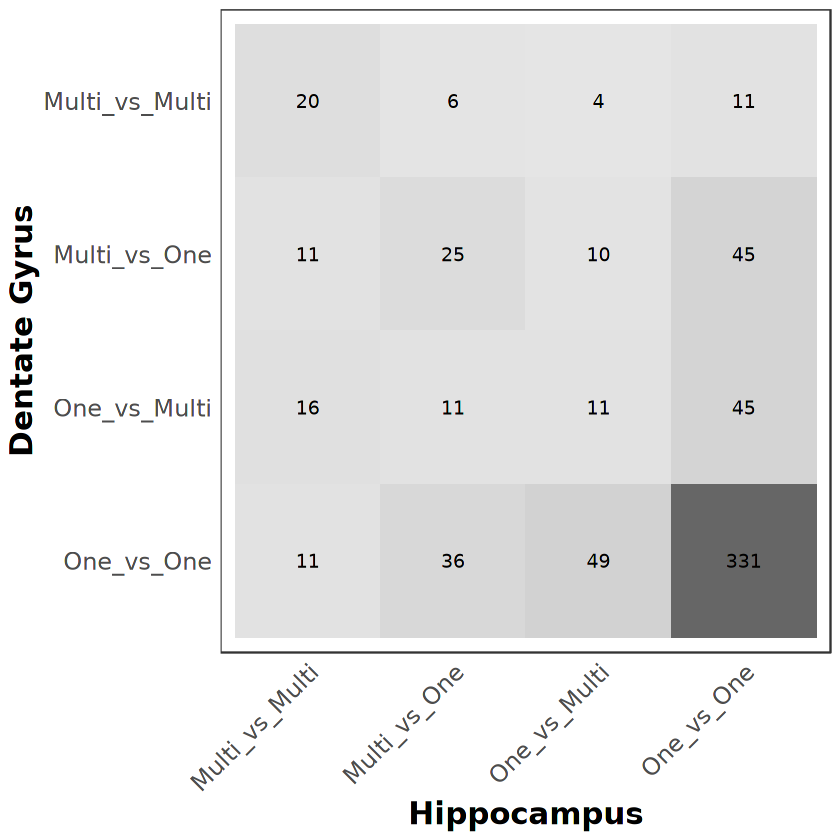

In [25]:
plot_heatmap(shared_df, "Caudate", "DLPFC")
plot_heatmap(shared_df, "Caudate", "Hippocampus")
plot_heatmap(shared_df, "Caudate", "Dentate_Gyrus")
plot_heatmap(shared_df, "DLPFC", "Hippocampus")
plot_heatmap(shared_df, "DLPFC", "Dentate_Gyrus")
plot_heatmap(shared_df, "Hippocampus", "Dentate_Gyrus")